# Networks of organisations


  
* *Exploratory SNA* book's chapter 5 about 'Affiliations'
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/pajek_book/chapter5_affiliations.ipynb) 



In [4]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet

%matplotlib inline

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import scipy.stats as stats

import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [6]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [7]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [6]:
print(reload(naf))  

<module 'network_analysis_functions' from '/Users/mariiaponomarova/Desktop/University/Bachelor 2/Humanités numeriques/poets/novelists/notebooks_jupyter/../network_analysis_functions.py'>


## Get the data from the triplestore

This notebook is based on the same relationships (and therefore data) as [the one about persons' relationships](wdt_persons_organisations_networks.ipynb), namely the relationship between persons and organisations as original information.

Here, however, we will focus on relationships between institutions, so the treatment is different.


In [10]:
## define SPARQL enpoint
endpoint = "https://ag10gz6eypmkc7tx.allegrograph.cloud/repositories/novelists"

In [13]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/mariaponomarova/novelists/blob/main/Wikidata/graph/imported-data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                # instance of
                wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [14]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


2923
[['http://www.wikidata.org/entity/Q11725003',
  'Jerzy Machnacz',
  '1949',
  'education',
  'http://www.wikidata.org/entity/Q175529',
  'John Paul II Catholic University of Lublin',
  '2',
  'Catholic university | university'],
 ['http://www.wikidata.org/entity/Q11725003',
  'Jerzy Machnacz',
  '1949',
  'employment',
  'http://www.wikidata.org/entity/Q11802875',
  'Papieski Fakultet Teologiczny we Wrocławiu',
  '3',
  'academic institution | organization | Catholic theological faculty'],
 ['http://www.wikidata.org/entity/Q11725003',
  'Jerzy Machnacz',
  '1949',
  'employment',
  'http://www.wikidata.org/entity/Q522109',
  'Wrocław University of Science and Technology',
  '3',
  'open-access publisher | polytechnic | organization']]


## Inspect the data


In [15]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesOrg']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  2923


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg
10,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,education,http://www.wikidata.org/entity/Q235034,University of Pittsburgh,5,private university | research university | pub...
11,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,employment,http://www.wikidata.org/entity/Q190080,Carnegie Mellon University,3,private university | research university | pri...
12,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,employment,http://www.wikidata.org/entity/Q174710,"University of California, Los Angeles",5,university campus | public research university...


### Distribution of relationships in relation to birthYears of organisations members

In [16]:
l_50 = list(range(1761, 2051, 30))
print(l_50)

[1761, 1791, 1821, 1851, 1881, 1911, 1941, 1971, 2001, 2031]


In [17]:
### We adapt the periods manually,
# we would like to have eight periods
# making sense from an historical point of view 
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]

In [18]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [19]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [20]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods
1,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,employment,http://www.wikidata.org/entity/Q219563,University of Washington,1,public university,1881-1910
5,http://www.wikidata.org/entity/Q102166958,Michael Hallett,1930,education,http://www.wikidata.org/entity/Q170027,University of London,4,educational organization | open-access publish...,1911-1940
10,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,education,http://www.wikidata.org/entity/Q235034,University of Pittsburgh,5,private university | research university | pub...,1941-1970


#### Reload from CSV

This is only possible if you already stored the data into a CSV, cf. below

In [21]:
### load from CSV

file_add = 'data/persons_organisations_from_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

2923


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,employment,http://www.wikidata.org/entity/Q165980,University of Vienna,1,university,1881-1910,['university']
1,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,employment,http://www.wikidata.org/entity/Q219563,University of Washington,1,public university,1881-1910,['public university']


In [22]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1751-1810      37
1811-1850     134
1851-1880     311
1881-1910     661
1911-1940    1056
1941-1970     724
dtype: int64


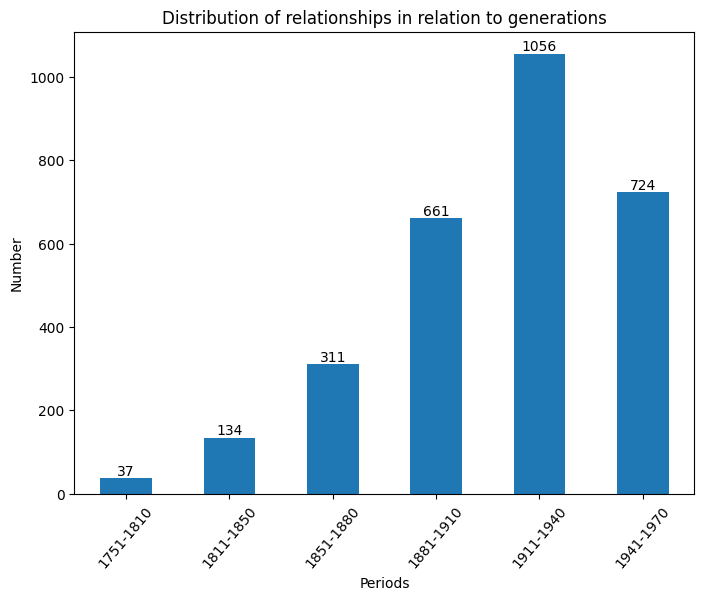

In [23]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Inspect available relationships

In [24]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1099
employment    1249
membership     575
dtype: int64


In [25]:
dfg_pr=df_p.groupby(by=['periods','relaType'], observed=True, as_index=False).size()
print(dfg_pr)

      periods    relaType  size
0   1751-1810   education    13
1   1751-1810  employment    10
2   1751-1810  membership    14
3   1811-1850   education    42
4   1811-1850  employment    50
5   1811-1850  membership    42
6   1851-1880   education   121
7   1851-1880  employment   121
8   1851-1880  membership    69
9   1881-1910   education   246
10  1881-1910  employment   262
11  1881-1910  membership   153
12  1911-1940   education   396
13  1911-1940  employment   482
14  1911-1940  membership   178
15  1941-1970   education   281
16  1941-1970  employment   324
17  1941-1970  membership   119


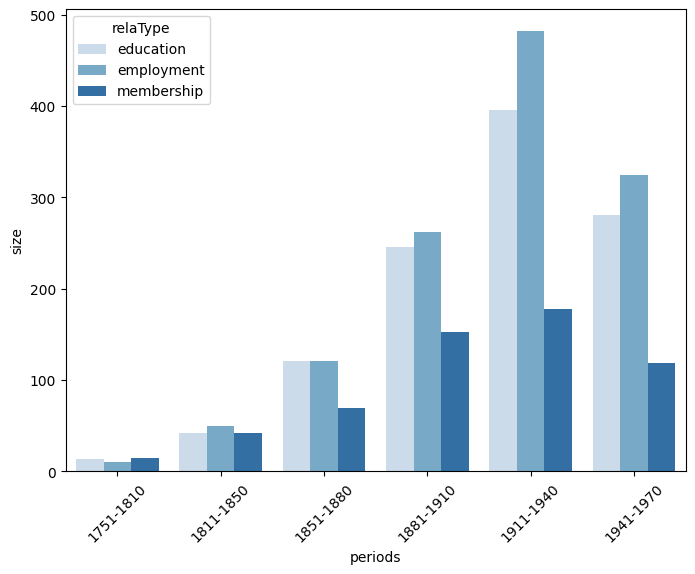

In [26]:
%matplotlib inline
plt.figure(figsize=(8, 6)) 
ax = sns.barplot(data=dfg_pr, x='periods', y='size', hue='relaType', palette='Blues')
ax.tick_params(axis='x', labelrotation=45)


### Clean up organisations type

In [27]:
### Transform types' strings to alphabetically sorted lists and delete additional white spaces
df_p['listTypesOrg'] = df_p.typesOrg.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

ll = df_p.listTypesOrg.to_list()
print(len(ll))
pprint.pprint(ll[:3])


2923
[['university'], ['public university'], ['university']]


In [28]:
## Rebuild the sorted original texts after sorting
df_p['typesOrg'] = df_p.listTypesOrg.apply(lambda x : ' | '.join(x))
df_p.iloc[[1,5,10]]


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
1,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,employment,http://www.wikidata.org/entity/Q219563,University of Washington,1,public university,1881-1910,[public university]
5,http://www.wikidata.org/entity/Q102166958,Michael Hallett,1930,education,http://www.wikidata.org/entity/Q170027,University of London,4,educational organization | higher education in...,1911-1940,"[educational organization, higher education in..."
10,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,education,http://www.wikidata.org/entity/Q235034,University of Pittsburgh,5,open-access publisher | private university | p...,1941-1970,"[open-access publisher, private university, pu..."


#### Organisations' types distribution

In [29]:
print(df_p.groupby('typesOrg').size().sort_values(ascending=False).iloc[:10])

typesOrg
university in france                                                                                                                  122
academic publisher | learned society | nonprofit organization                                                                         106
colonial colleges | private not-for-profit educational institution | private university | research university                          94
university                                                                                                                             73
public university                                                                                                                      69
academic publisher | colonial colleges | private not-for-profit educational institution | private university | research university     59
comprehensive university | open-access publisher | public research university | university of excellence                               55
faculty                  

#### Save dataframe to CSV

In [30]:
file_add = 'data/persons_organisations_from_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

## Types of organisations

Property **wdt:P31 instance of**


We are trying to figure out if we can use these types to distinguish and categorise organisations. We will introduce high-level, research-driven classes that primarily serve a heuristic function and express no objective point of view.

In [32]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby('typesOrg').size().sort_values(ascending=False))
df_types.reset_index(inplace=True)
df_types.columns=['typesOrg', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
df_types.iloc[:10]

,typesOrg,number,numberOrg
0,university in france,122,1
1,academic publisher | learned society | nonprof...,106,3
2,colonial colleges | private not-for-profit edu...,94,4
3,university,73,1
4,public university,69,1
5,academic publisher | colonial colleges | priva...,59,5
6,comprehensive university | open-access publish...,55,4
7,faculty,45,1
8,open-access publisher | public university,44,2
9,academy of sciences,42,1


In [33]:
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_types_groups.csv'
df_types.to_csv(csv_file)

### Add organisation main type

In [34]:
### Inspect the data
df_p.head(1)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg
0,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,employment,http://www.wikidata.org/entity/Q165980,University of Vienna,1,university,1881-1910,[university]


In [35]:
def code_organisation_main_type(x):
    val = ''
    if 'institute of technol' in x:
        val = 'institute of technology'
    elif 'polyt' in x:
        val = 'institute of technology'    
    elif 'observato' in x:
        val = 'astronomical observatory'  
    elif 'public university' in x:
        val = 'public university'
    elif 'école normale sup' in x:
        val = 'public university'    
    elif 'grande école' in x:
        val = 'public university'
    elif 'grand établissement' in x:
        val = 'public university'
    elif 'private university' in x:
        val = 'private university'
    elif 'university' in x:
        val = 'university'   
    elif 'educational inst' in x:
        val = 'educational institution'    
    elif 'military academy' in x:
        val = 'educational institution' 
    elif 'naval academy' in x:
        val = 'educational institution'        
    elif 'art academy' in x:
        val = 'educational institution' 
    elif 'faculty' in x:
        val = 'university'  # could also be 'faculty'
    elif 'academic dep' in x:
        val =  'university'  # could also be 'faculty'    
    elif 'college' in x:
        val = 'educational institution'   # could also be 'college'             
    elif 'gymnas' in x:
        val = 'educational institution'   # could also be 'college'
    elif 'learned society' in x:
        val = 'learned society'     
    elif 'academy of sciences' in x:
        val = 'academy of sciences'
    elif 'research institute' in x:
        val = 'research organisation'
    elif 'max planck' in x:
        val = 'research organisation'
    elif 'institute' in x:
        val = 'research organisation' 
    elif 'research' in x:
        val = 'research organisation'
    elif 'laboratory' in x:
        val = 'research facility'  
    elif 'facility' in x:
        val = 'research facility'   
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'scientific society' in x:
        val = 'scientific organisation'
    elif 'museum' in x:
        val = 'scientific organisation'
    elif 'nonprofit organization' in x:
        val = 'scientific organisation'    
    elif 'national academy' in x:
        val = 'scientific organisation'
    elif 'scientific organization' in x:
        val = 'scientific organisation'
    elif 'higher education' in x:
        val = 'educational institution'
    elif 'school' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academic institution' in x:
        val = 'educational institution'   # could also be 'high school or similar'
    elif 'academy' in x:
        val = 'learned society'
    elif 'society' in x:
        val = 'learned society'      
    elif 'company' in x \
                or 'business'  in x \
                or 'entrepr' in x:
        val = 'company or gov. agency' # could also be 'company'
    elif 'government' in x :
        val = 'company or gov. agency' # could also be 'government agency'         
    elif 'publish' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'     
    elif 'journal' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'
    elif 'periodical' in x :
        val = 'company or gov. agency' # could also be 'publisher_edition'    
    else:
        val = 'not classified organisation'

    return val        

In [37]:
df_p['orgMainType'] = df_p['typesOrg'].apply(lambda x : code_organisation_main_type(x))
df_p.iloc[7:10]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
7,http://www.wikidata.org/entity/Q102289020,Oswaldo Chateaubriand,1940,education,http://www.wikidata.org/entity/Q168756,"University of California, Berkeley",4,land-grant university | public educational ins...,1911-1940,"[land-grant university, public educational ins...",university
8,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,employment,http://www.wikidata.org/entity/Q41506,Stanford University,4,open-access publisher | private not-for-profit...,1941-1970,"[open-access publisher, private not-for-profit...",private university
9,http://www.wikidata.org/entity/Q102316377,Thomas Schwartz,1943,education,http://www.wikidata.org/entity/Q49119,Brandeis University,3,private not-for-profit educational institution...,1941-1970,[private not-for-profit educational institutio...,university


In [38]:
df_mainTypes = pd.DataFrame(df_p.groupby(by='orgMainType', as_index=False).size().sort_values(by='size',ascending=False))
df_mainTypes.columns=['mainType', 'number']
df_mainTypes

,mainType,number
12,university,943
8,public university,650
7,private university,373
5,learned society,214
3,educational institution,199
0,academy of sciences,190
6,not classified organisation,176
10,research organisation,57
11,scientific organisation,43
9,research facility,29


In [39]:
### Inspect the available composed types
df_types = pd.DataFrame(df_p.groupby(['typesOrg', 'orgMainType'], as_index=False).\
                        size().sort_values(by='size',ascending=False))
df_types.columns=['typesOrg', 'orgMainType', 'number']
df_types['numberOrg'] = df_types.typesOrg.apply( lambda x: len(x.split('|')))
### Print to CSV in order to inspect the data
csv_file='data/network_organisations_with_main_types_groups.csv'
df_types.to_csv(csv_file)

df_types.iloc[7:10]

,typesOrg,orgMainType,number,numberOrg
230,faculty,university,45,1
408,open-access publisher | public university,public university,44,2
29,academy of sciences,academy of sciences,42,1


#### 'Manual' corrections and classification improvements

In some cases, instpecting the organisations shows that the provided classification is not suitable and should be replaced:

Academia Europaea, ...

We provide this example merely to illustrate the point; further work would be required, but this is beyond the scope of this exercise.

In [40]:
### Please note the warning and the orders fo the filter, after (!) the column 
"""
Do not use:
df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
"""

df_p.loc[df_p.uriOrg == 'http://www.wikidata.org/entity/Q337234', 'orgMainType'] = 'research organisation'
df_p[df_p.labelOrg.str.contains('Europaea')].head(2)



,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesOrg,periods,listTypesOrg,orgMainType
85,http://www.wikidata.org/entity/Q1157217,Dagfinn Føllesdal,1932,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1911-1940,"[academy, charitable organization, organization]",research organisation
359,http://www.wikidata.org/entity/Q15428235,Wolfgang Spohn,1950,membership,http://www.wikidata.org/entity/Q337234,Academia Europaea,3,academy | charitable organization | organization,1941-1970,"[academy, charitable organization, organization]",research organisation


# Create graphs

In [41]:
### Available relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1099
employment    1249
membership     575
dtype: int64


### Prepare the dataframe

In [42]:
### Select the columns that will be used
df_prep = df_p[['uriPer','labelPer','birthYear','uriOrg', 'labelOrg', 'typesOrg', 'orgMainType', 'relaType', 'periods']].copy(deep=True)
print(len(df_prep))

2923


### Features of organisations

#### General grouping


We first group by organisations, counting all relationships of persons which provides the total degree or number of members over the whole time 

In [43]:
### Memberships by organisations
df_org = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'typesOrg','orgMainType'],as_index=False).size())
df_org.columns=['uriOrg', 'labelOrg', 'typesOrg', 'orgMainType','tot_members_number']
df_org.sort_values('tot_members_number',ascending=False).iloc[:10]

,uriOrg,labelOrg,typesOrg,orgMainType,tot_members_number
577,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,academic publisher | learned society | nonprof...,learned society,106
114,http://www.wikidata.org/entity/Q13371,Harvard University,colonial colleges | private not-for-profit edu...,private university,88
317,http://www.wikidata.org/entity/Q21578,Princeton University,academic publisher | colonial colleges | priva...,private university,54
162,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,comprehensive university | open-access publish...,university,48
177,http://www.wikidata.org/entity/Q154804,Leipzig University,comprehensive university | open-access publish...,public university,37
600,http://www.wikidata.org/entity/Q49088,Columbia University,colonial colleges | organization | private not...,private university,35
157,http://www.wikidata.org/entity/Q151510,Heidelberg University,comprehensive university | open-access publish...,public university,34
168,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,34
107,http://www.wikidata.org/entity/Q131252,University of Chicago,private not-for-profit educational institution...,private university,33
124,http://www.wikidata.org/entity/Q1394262,Paris Nanterre University,university in france,university,32


In [44]:
### Save list of organisations as CSV
csv_file='data/network_organisations_with_main_type_and_number.csv'
df_org.sort_values('tot_members_number',ascending=False).to_csv(csv_file)

#### Group by period

We then group by heuristic period (or generation)

In [46]:
df_orgPeriod = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriod.reset_index(inplace=True)
df_orgPeriod.sort_values(by='periods', ascending=True).head()

,uriOrg,labelOrg,orgMainType,periods,period_members_number
245,http://www.wikidata.org/entity/Q153978,University of Tübingen,public university,1751-1810,1
236,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1751-1810,2
258,http://www.wikidata.org/entity/Q154561,Friedrich Schiller University Jena,public university,1751-1810,3
527,http://www.wikidata.org/entity/Q2296836,Societas Jablonoviana,not classified organisation,1751-1810,1
263,http://www.wikidata.org/entity/Q154804,Leipzig University,public university,1751-1810,5


In [48]:
df_orgPeriod[df_orgPeriod.labelOrg=='University of Göttingen']

,uriOrg,labelOrg,orgMainType,periods,period_members_number
236,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1751-1810,2
237,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1811-1850,6
238,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1851-1880,3
239,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1881-1910,21
240,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,1911-1940,2


#### Group by period and relationship type

We then group by heuristic period (or generation) AND relationship type, i.e. which kind of relationship associates a person to an organisation in the bipartite network

In [49]:
df_orgPeriodRelType = pd.DataFrame(df_prep.groupby(['uriOrg', 'labelOrg', 'orgMainType', 'relaType', 'periods']).size(), columns=['period_members_number'])
df_orgPeriodRelType.reset_index(inplace=True)
df_orgPeriodRelType.sort_values(by='period_members_number', ascending=False).head()

,uriOrg,labelOrg,orgMainType,relaType,periods,period_members_number
1085,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1911-1940,48
1084,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1881-1910,27
177,http://www.wikidata.org/entity/Q13371,Harvard University,private university,education,1911-1940,26
1086,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,membership,1941-1970,22
618,http://www.wikidata.org/entity/Q21578,Princeton University,private university,education,1911-1940,16


In [51]:
### Number of relationships by period with type
dfgt = df_orgPeriodRelType.groupby(['periods', 'relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values(['relaType', 'periods'])
file_addr='data/organisations_types_periods_distribution.csv'
dfgt.sort_values(['relaType', 'periods']).to_csv(file_addr)
print(len(dfgt))
dfgt.iloc[:10]

122


,periods,relaType,orgMainType,period_members_number
0,1751-1810,education,educational institution,3
1,1751-1810,education,not classified organisation,1
2,1751-1810,education,public university,7
3,1751-1810,education,university,2
9,1811-1850,education,educational institution,5
10,1811-1850,education,not classified organisation,1
11,1811-1850,education,private university,1
12,1811-1850,education,public university,21
13,1811-1850,education,university,14
26,1851-1880,education,educational institution,14


In [52]:
### Number of relationships without period
dfgw = df_orgPeriodRelType.groupby(['relaType', 'orgMainType'], as_index=False)\
    .sum('members').sort_values([ 'relaType', 'orgMainType'])
print(len(dfgw))

28


## Bivariate analysis: relationship, organisation type

### Create the needed functions

In [53]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [54]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

    return residus_ponderes

### Explore contingency table : types of relationships, types of organisations

In [55]:


### Contingency table
X = 'relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



relaType,education,employment,membership,Total
orgMainType,,,,
academy of sciences,0,9,181,190
astronomical observatory,0,3,0,3
company or gov. agency,0,13,6,19
educational institution,113,66,20,199
institute of technology,11,16,0,27
learned society,0,1,200,201
not classified organisation,18,56,102,176
private university,168,205,0,373
public university,331,319,0,650


In [56]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

relaType,education,employment,membership
orgMainType,,,
academy of sciences,0,9,181
astronomical observatory,0,3,0
company or gov. agency,0,13,6
educational institution,113,66,20
institute of technology,11,16,0
learned society,0,1,200
not classified organisation,18,56,102
private university,168,205,0
public university,331,319,0


In [57]:
### We observe a strong relationship between these two variables

bivariee_stats(ct_wm)

Chi2 : 2408.21 , dof : 24
p-value : 0.0
phi2 = inertie (variance totale) : 0.8238820797104991
Cramer:  0.6418263315377841


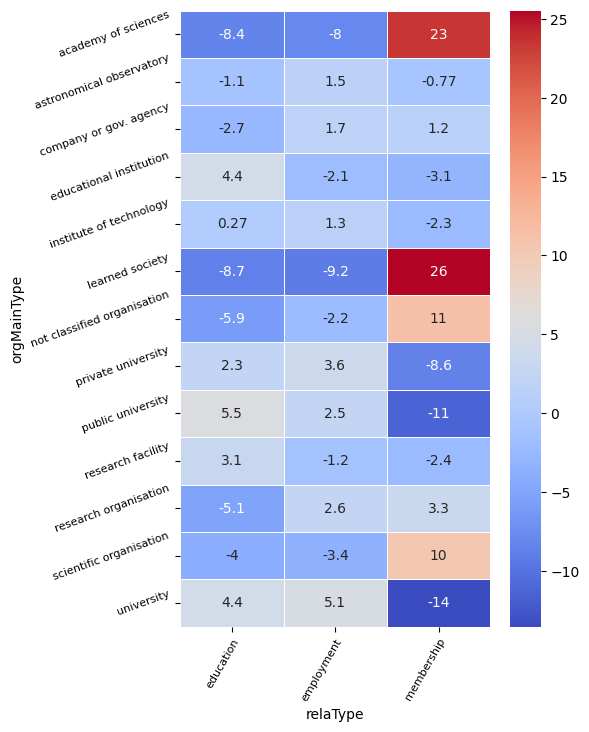

In [58]:
pp = plot_chi2_residuals(ct_wm, figsize=(5, 8))

#### Comment

We observe a strong relationship between these two variables which is explained by the fact that not all organisations types are concerned by the same relationship types

We also observe that some values should be corrected, like memberships in technical organisations that should be employments.

See the following example

In [59]:
pprint.pprint(list(df_p.loc[df_p.orgMainType.str.contains('techno') & df_p.relaType.str.contains('memb') ].items())[:6])

[('uriPer', Series([], Name: uriPer, dtype: object)),
 ('labelPer', Series([], Name: labelPer, dtype: object)),
 ('birthYear', Series([], Name: birthYear, dtype: int64)),
 ('relaType', Series([], Name: relaType, dtype: object)),
 ('uriOrg', Series([], Name: uriOrg, dtype: object)),
 ('labelOrg', Series([], Name: labelOrg, dtype: object))]


### Explore contingency table of relationships to organisations : periods, types of organisations

In [60]:
### Contingency table
X = 'periods'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,Total
orgMainType,,,,,,,
academy of sciences,10,29,24,60,53,14,190
astronomical observatory,0,1,0,2,0,0,3
company or gov. agency,0,0,2,4,7,6,19
educational institution,3,9,24,55,68,40,199
institute of technology,0,0,1,7,11,8,27
learned society,3,6,16,53,76,47,201
not classified organisation,2,8,29,37,47,53,176
private university,0,3,20,83,178,89,373
public university,16,44,96,189,186,119,650


In [61]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [62]:
### We observe some not so strong relationship between these two variables
bivariee_stats(ct_wm)

Chi2 : 322.37 , dof : 60
p-value : 1.4106603311779454e-37
phi2 = inertie (variance totale) : 0.11028762890589419
Cramer:  0.1485177625106803


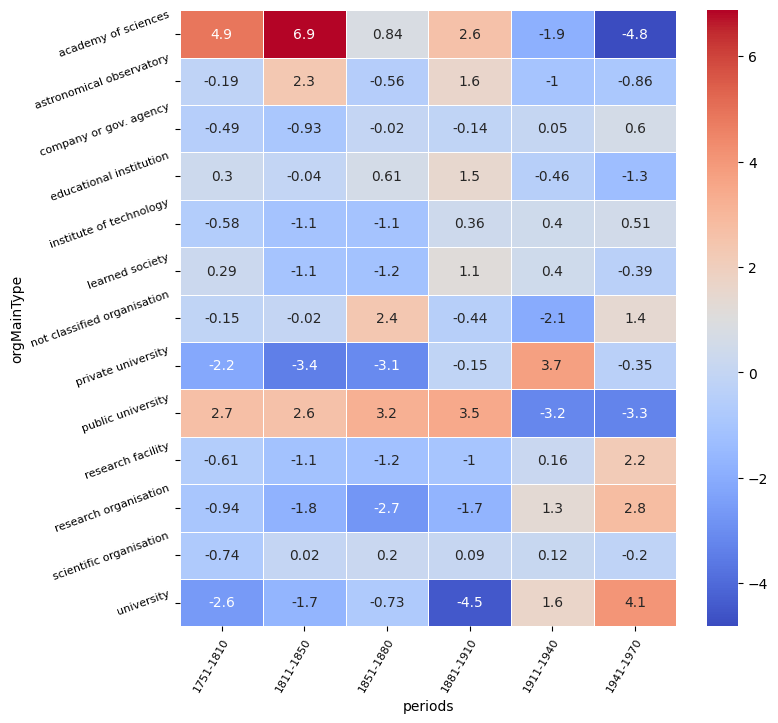

In [63]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 8))

### Explore contingency table of relationships to organisations : periods, types of relationships

In [64]:
### Contingency table
X = 'periods'
Y = 'relaType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,Total
relaType,,,,,,,
education,13,42,121,246,396,281,1099
employment,10,50,121,262,482,324,1249
membership,14,42,69,153,178,119,575
Total,37,134,311,661,1056,724,2923


In [65]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [66]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 38.95 , dof : 10
p-value : 2.590750090507169e-05
phi2 = inertie (variance totale) : 0.013325284661375059
Cramer:  0.08162501044831498


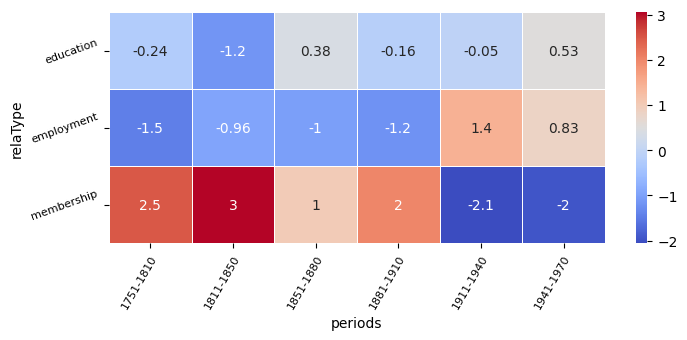

In [67]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 3))

### Explore contingency table of relationships to organisations : periods+types of relationships vs organisations types

In [68]:
df_prep['periods_relaType'] = df_prep.apply(lambda x : x.periods+'_'+x.relaType, axis=1)
df_prep.head(1)

,uriPer,labelPer,birthYear,uriOrg,labelOrg,typesOrg,orgMainType,relaType,periods,periods_relaType
0,http://www.wikidata.org/entity/Q101112434,Amalia Rosenblüth,1892,http://www.wikidata.org/entity/Q165980,University of Vienna,university,university,employment,1881-1910,1881-1910_employment


In [69]:
### Contingency table
X = 'periods_relaType'
Y = 'orgMainType'  

ddf = df_prep[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods_relaType,1751-1810_education,1751-1810_employment,1751-1810_membership,1811-1850_education,1811-1850_employment,1811-1850_membership,1851-1880_education,1851-1880_employment,1851-1880_membership,1881-1910_education,1881-1910_employment,1881-1910_membership,1911-1940_education,1911-1940_employment,1911-1940_membership,1941-1970_education,1941-1970_employment,1941-1970_membership,Total
orgMainType,,,,,,,,,,,,,,,,,,,
academy of sciences,0,0,10,0,0,29,0,0,24,0,1,59,0,7,46,0,1,13,190
astronomical observatory,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,3
company or gov. agency,0,0,0,0,0,0,0,0,2,0,2,2,0,6,1,0,5,1,19
educational institution,3,0,0,5,3,1,14,7,3,29,17,9,38,25,5,24,14,2,199
institute of technology,0,0,0,0,0,0,1,0,0,4,3,0,1,10,0,5,3,0,27
learned society,0,0,3,0,0,6,0,0,16,0,0,53,0,1,75,0,0,47,201
not classified organisation,1,0,1,1,2,5,2,8,19,2,15,20,5,15,27,7,16,30,176
private university,0,0,0,1,2,0,6,14,0,32,51,0,90,88,0,39,50,0,373
public university,7,9,0,21,23,0,48,48,0,107,82,0,85,101,0,63,56,0,650


In [70]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [71]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 3107.12 , dof : 204
p-value : 0.0
phi2 = inertie (variance totale) : 1.06299093819823
Cramer:  0.29762825501485213


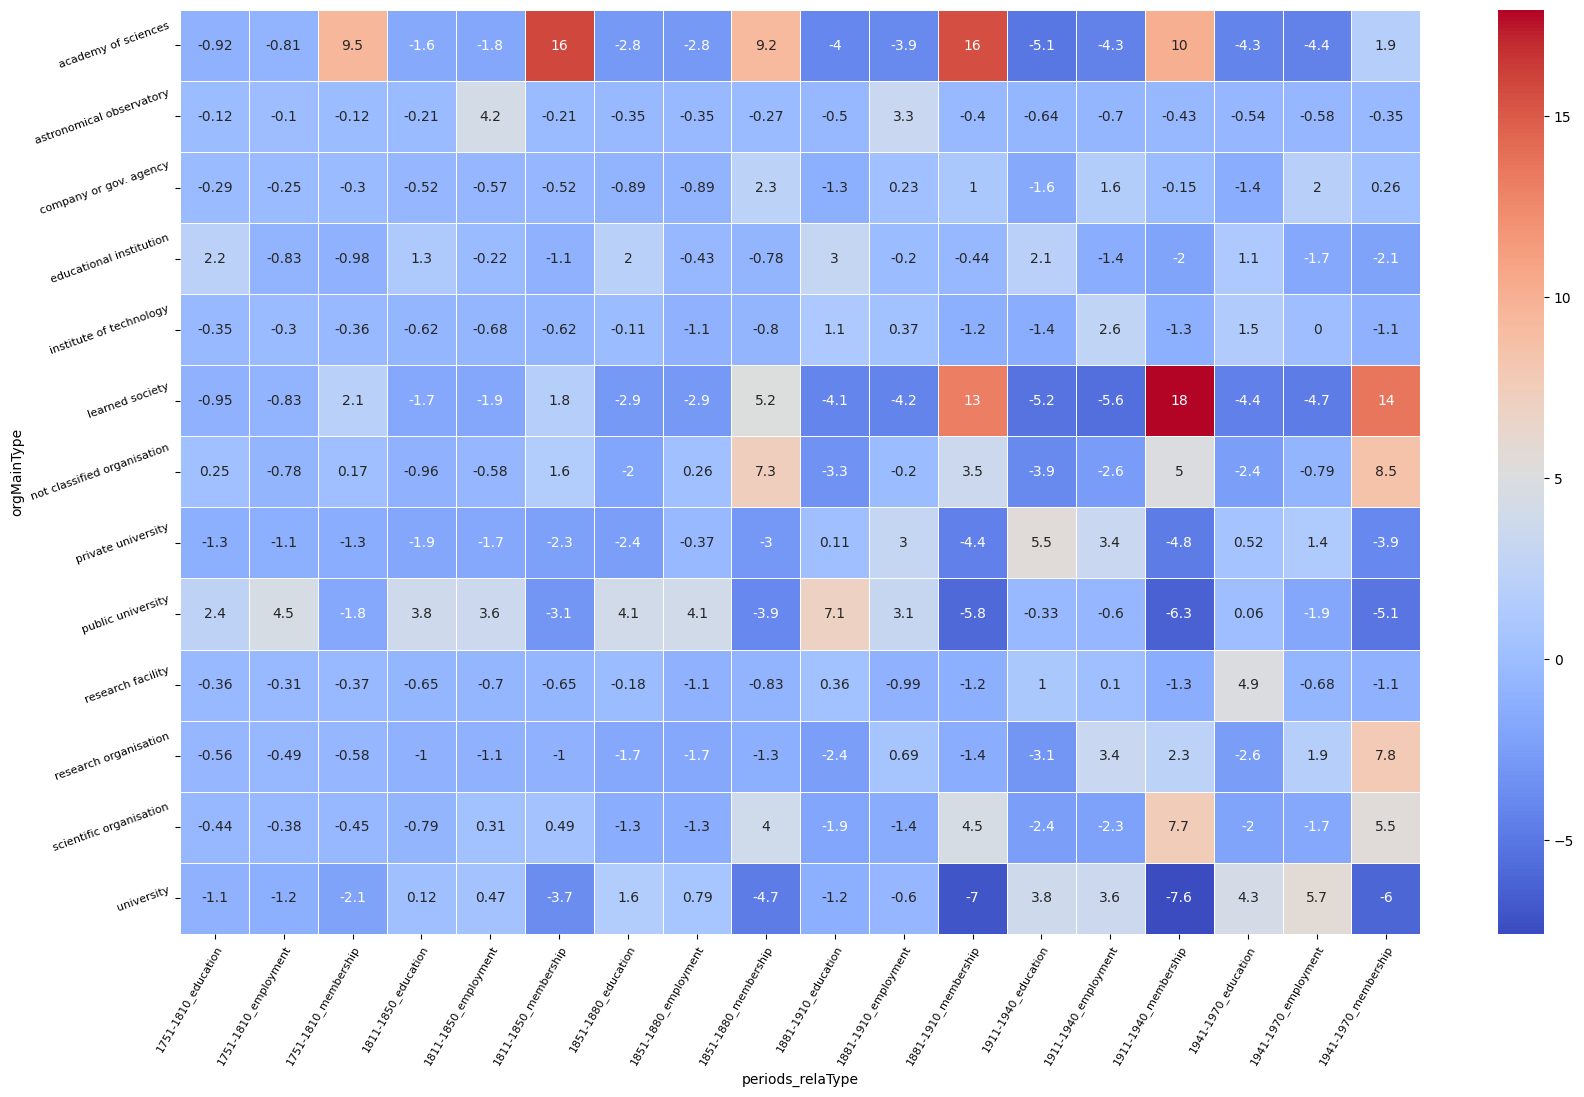

In [72]:
pp = plot_chi2_residuals(ct_wm, figsize=(20, 12))

## Prepare graph


In a heuristic perspective we take the persons as representing relationships among organisations.

Of course these relations are limited in time and with different meaning but in this general inspection of the field, we consider all the relationship. Filters are introduced later on.

We will create a projection of the graph on organisations and keep in a first stage all relationships, with types and periods, one per relationship, where the joining elements are those concerning uniquely the person

In [73]:
### Join on common organisation: Cartesian product -> produces a lot of rows !
merged = pd.merge(df_prep, df_prep, on=['uriPer','labelPer','birthYear', 'periods'])
print(len(merged))


19755


In [74]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriOrg_x'] < (merged['uriOrg_y'])]


In [75]:
### Inspect
print(len(merged))
print(list(merged.columns))
merged.iloc[110:114]

8204
['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
300,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1851-1880_employment
301,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,academy of sciences,academy of sciences,membership,1851-1880_membership
302,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q329464,Royal Prussian Academy of Sciences,academy of sciences,academy of sciences,membership,1851-1880_membership
304,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,employment,1851-1880_employment


In [76]:
### Available ORIGINAL relationships
print(df_p.groupby(by='relaType').size())

relaType
education     1099
employment    1249
membership     575
dtype: int64


In [77]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
4,employment,employment,1472
1,education,employment,1172
3,employment,education,1138
5,employment,membership,997
0,education,education,812
8,membership,membership,736
2,education,membership,729
7,membership,employment,591
6,membership,education,557


### Swap values in order to have the same orientation for all relationships

All relationships should have the same 'orientation', which is determined by alphabetical order:

education -> employment -> membership

In [79]:
### Example
df = pd.DataFrame({
    'column1': ['A', 'B', 'C', 'D'],
    'column2': ['X', 'Y', 'Z', 'W']
})

condition = df['column1'] < df['column2']
df.loc[condition, ['column1', 'column2']] = df.loc[condition, ['column2', 'column1']].values

print(df)

  column1 column2
0       X       A
1       Y       B
2       Z       C
3       W       D


In [80]:
### Test whether the relationship types are in the wrong alphabetical order.
condition = merged.relaType_x > merged.relaType_y

In [81]:
### Transpose under condition that the relation orientation is 'wrong',
# i.e. not according the alphabatical order

merged.loc[condition, 
    ['uriOrg_x','labelOrg_x','orgMainType_x','relaType_x', 'uriOrg_y','labelOrg_y','orgMainType_y','relaType_y']] = \
        merged.loc[condition,
    ['uriOrg_y','labelOrg_y','orgMainType_y','relaType_y','uriOrg_x','labelOrg_x','orgMainType_x','relaType_x']].values

In [82]:
### Inspect

merged.iloc[110:117]

,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y
300,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1851-1880_employment
301,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,academy of sciences,academy of sciences,membership,1851-1880_membership
302,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q329464,Royal Prussian Academy of Sciences,academy of sciences,academy of sciences,membership,1851-1880_membership
304,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,employment,1851-1880_employment
306,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q833738,Heidelberg Academy for Sciences and Humanities,academy of sciences | building,academy of sciences,membership,1851-1880_membership
307,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,campus university | comprehensive university |...,public university,education,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q152838,University of Göttingen,comprehensive university | open-access publish...,public university,employment,1851-1880_education
309,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q152838,University of Göttingen,campus university | comprehensive university |...,public university,employment,1851-1880,1851-1880_employment,http://www.wikidata.org/entity/Q414188,Göttingen Academy of Sciences and Humanities i...,academy of sciences,academy of sciences,membership,1851-1880_membership


In [84]:
### Number of relationships per type prepared for graph
gl_relaType = merged.groupby(['relaType_x', 'relaType_y'], as_index=False).size().sort_values(by='size', ascending=False)

gl_relaType


,relaType_x,relaType_y,size
1,education,employment,2310
4,employment,membership,1588
3,employment,employment,1472
2,education,membership,1286
0,education,education,812
5,membership,membership,736


In [85]:
### Concat relationships
merged['relaType_concat'] = merged.apply(lambda x: x.relaType_x + '_' +x.relaType_y, axis=1)

In [86]:
print(list(merged.columns))
merged.iloc[110:112]


['uriPer', 'labelPer', 'birthYear', 'uriOrg_x', 'labelOrg_x', 'typesOrg_x', 'orgMainType_x', 'relaType_x', 'periods', 'periods_relaType_x', 'uriOrg_y', 'labelOrg_y', 'typesOrg_y', 'orgMainType_y', 'relaType_y', 'periods_relaType_y', 'relaType_concat']


,uriPer,labelPer,birthYear,uriOrg_x,labelOrg_x,typesOrg_x,orgMainType_x,relaType_x,periods,periods_relaType_x,uriOrg_y,labelOrg_y,typesOrg_y,orgMainType_y,relaType_y,periods_relaType_y,relaType_concat
300,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q206702,University of Zurich,comprehensive university | university,university,employment,1851-1880_employment,education_employment
301,http://www.wikidata.org/entity/Q109093,Heinrich Maier,1867,http://www.wikidata.org/entity/Q153978,University of Tübingen,comprehensive university | open-access publish...,public university,education,1851-1880,1851-1880_education,http://www.wikidata.org/entity/Q1636237,Royal Danish Academy of Sciences and Letters,academy of sciences,academy of sciences,membership,1851-1880_membership,education_membership


In [87]:
df_graph=merged.groupby(['periods', 'relaType_concat', 'uriOrg_x', 'labelOrg_x', 'orgMainType_x',  
                         'uriOrg_y', 'labelOrg_y', 'orgMainType_y'],
               as_index=False)\
    .agg({'labelPer': '|'.join, 'uriPer': '|'.join})

df_graph['number'] = df_graph.labelPer.apply(lambda x : len(x.split('|')))


In [88]:
print(len(df_graph))
df_graph.sort_values('number',ascending=False).head()


7471


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
4586,1911-1940,education_membership,http://www.wikidata.org/entity/Q13371,Harvard University,private university,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Dagfinn Føllesdal|Jacques Derrida|T. M. Scanlo...,http://www.wikidata.org/entity/Q1157217|http:/...,13
3456,1881-1910,membership_membership,http://www.wikidata.org/entity/Q270794,National Academy of Sciences,academy of sciences,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Norbert Wiener|Edward Sapir|Alfred Tarski|Wolf...,http://www.wikidata.org/entity/Q178577|http://...,12
4667,1911-1940,education_membership,http://www.wikidata.org/entity/Q21578,Princeton University,private university,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Robert Stalnaker|George Boolos|Paul Benacerraf...,http://www.wikidata.org/entity/Q1364893|http:/...,9
5896,1911-1940,membership_membership,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,http://www.wikidata.org/entity/Q723551,British Academy,learned society,Robert Stalnaker|Joseph Raz|John Rawls|Ian Hac...,http://www.wikidata.org/entity/Q1364893|http:/...,8
5546,1911-1940,employment_membership,http://www.wikidata.org/entity/Q21578,Princeton University,private university,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,Paul Benacerraf|John Rawls|T. M. Scanlon|Richa...,http://www.wikidata.org/entity/Q1396649|http:/...,8


### Explore contingency table of relationship pairs to periods

In [89]:


### Contingency table
X = 'periods'
Y = 'relaType_concat'  

ddf = df_graph[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,Total
relaType_concat,,,,,,,
education_education,13,41,112,201,232,157,756
education_employment,21,90,233,534,756,525,2159
education_membership,28,98,172,318,321,206,1143
employment_employment,7,51,130,331,538,350,1407
employment_membership,35,116,181,415,382,244,1373
membership_membership,56,62,78,236,125,76,633
Total,160,458,906,2035,2354,1558,7471


In [90]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)

In [91]:
### We observe a relationship between these two variables, 
# not so strong 
bivariee_stats(ct_wm)

Chi2 : 423.72 , dof : 25
p-value : 4.23591483105922e-74
phi2 = inertie (variance totale) : 0.05671587130957424
Cramer:  0.10650433916941998


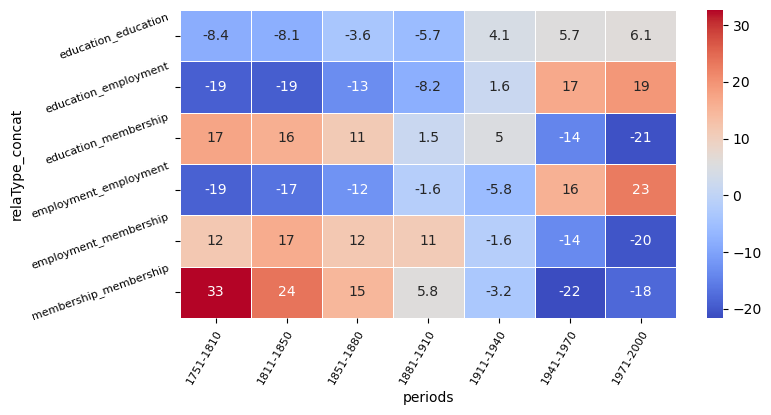

In [71]:
pp = plot_chi2_residuals(ct_wm, figsize=(8, 4))

## Graph analysis


We will explore some aspects of the relationships:

* which organisations are connected through education, but this only at the level of universities, not earlier education stages
* in the same perspective (same kind of relations), we will explore memberships and employments, keeping them separated
* we will then ask what appears regarding the relationship between employment and membership
* we finally inspect if some kind of educational institutions (at unversity level) lead to specific employments or memberships.






### Organisations connected through higher education

In [92]:
pprint.pprint(sorted(df_mainTypes.mainType.to_list()))

['academy of sciences',
 'astronomical observatory',
 'company or gov. agency',
 'educational institution',
 'institute of technology',
 'learned society',
 'not classified organisation',
 'private university',
 'public university',
 'research facility',
 'research organisation',
 'scientific organisation',
 'university']


In [93]:
types_list=['university', 'public university', 'private university']

In [94]:
df_edu_graph = df_graph[(df_graph.relaType_concat == 'education_education') \
                     & (df_graph.orgMainType_x.isin(types_list)) \
                     & (df_graph.orgMainType_y.isin(types_list))  ]

print(len(df_edu_graph))
df_edu_graph.iloc[:2]

467


,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
3,1751-1810,education_education,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,university,http://www.wikidata.org/entity/Q156737,Kiel University,public university,Johann Eduard Erdmann,http://www.wikidata.org/entity/Q64623,1
4,1751-1810,education_education,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,university,http://www.wikidata.org/entity/Q28024477,Imperial University of Dorpat,university,Johann Eduard Erdmann,http://www.wikidata.org/entity/Q64623,1


In [95]:
df_edu_graph.sort_values(by='number',ascending=False).iloc[:2]

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1579,1881-1910,education_education,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,university,http://www.wikidata.org/entity/Q153987,University of Freiburg,public university,Hans Jonas|Herbert Marcuse|Walter Benjamin|Rud...,http://www.wikidata.org/entity/Q57255|http://w...,4
1606,1881-1910,education_education,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,public university,Nae Ionescu|Gerhard Gentzen|Hermann Weyl|Karl ...,http://www.wikidata.org/entity/Q1380594|http:/...,4


In [96]:
### Number of relationships by period
print(df_edu_graph.groupby('periods').size())

periods
1751-1810      5
1811-1850     26
1851-1880     68
1881-1910    122
1911-1940    150
1941-1970     96
dtype: int64


### Inspect a specific period

In [97]:
p = '1881-1910' #'1851-1880' #'1911-1940'

In [98]:
df_edu_graph_p = df_edu_graph[(df_edu_graph.periods==p)]
df_edu_graph_p.sort_values(by='number',ascending=False).head(2)

,periods,relaType_concat,uriOrg_x,labelOrg_x,orgMainType_x,uriOrg_y,labelOrg_y,orgMainType_y,labelPer,uriPer,number
1606,1881-1910,education_education,http://www.wikidata.org/entity/Q152838,University of Göttingen,public university,http://www.wikidata.org/entity/Q55044,Ludwig-Maximilians-Universität München,public university,Nae Ionescu|Gerhard Gentzen|Hermann Weyl|Karl ...,http://www.wikidata.org/entity/Q1380594|http:/...,4
1579,1881-1910,education_education,http://www.wikidata.org/entity/Q152087,Humboldt-Universität zu Berlin,university,http://www.wikidata.org/entity/Q153987,University of Freiburg,public university,Hans Jonas|Herbert Marcuse|Walter Benjamin|Rud...,http://www.wikidata.org/entity/Q57255|http://w...,4


In [99]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriOrg_x'], e['uriOrg_y'],
     {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
      ## the weight ist the number of persons in this relationship
      'weight':e['number']}
     )) 
     for e in df_edu_graph_p.to_dict(orient='records')]
print(len(l))

122


In [100]:
edu_graph_p=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
edu_graph_p.add_edges_from(l)

naf.basic_graph_properties(edu_graph_p)

### Create a list of graphs, one per component
edu_graph_p_S = [edu_graph_p.subgraph(c).copy() for c in nx.connected_components(edu_graph_p)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(edu_graph_p_S)], key = lambda row: row[1], reverse=True)
print(ln[:5])

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 59,
 'number_of_edges': 122,
 '------': '------',
 'is connected': False,
 'components': 5,
 'density': 0.07130333138515488}
[[1, 51], [0, 2], [2, 2], [3, 2], [4, 2]]


In [101]:
### test if second component is significantly smaller 
# than first
if ln[1][1]*20 < ln[0][1]:
    print('Just one big component')
else :
    print('Beware: more than one big component !')    

Just one big component


In [102]:
### Alternative way with just one graph
pG = edu_graph_p_S[0]
naf.basic_graph_properties(pG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2,
 'number_of_edges': 1,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 1.0}


In [103]:
df_orgPeriod.sort_values(by='period_members_number', ascending=False).head(2)

,uriOrg,labelOrg,orgMainType,periods,period_members_number
895,http://www.wikidata.org/entity/Q463303,American Academy of Arts and Sciences,learned society,1911-1940,48
157,http://www.wikidata.org/entity/Q13371,Harvard University,private university,1911-1940,42


In [104]:
df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']
df_opl.head()


,uri,label,mainType,membersNumber
6,http://www.wikidata.org/entity/Q1041737,Carleton University,university,1
14,http://www.wikidata.org/entity/Q1059546,Lycée Louis-le-Grand,research facility,1
17,http://www.wikidata.org/entity/Q1062129,Tohoku University,university,1
29,http://www.wikidata.org/entity/Q1093910,City College of New York,educational institution,6
33,http://www.wikidata.org/entity/Q1095773,Clark University,private university,1


In [105]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'mainType':e['mainType'],
                        'membersNumber':e['membersNumber']}
     ) for e in df_opl.to_dict(orient='records')])
## Add attributes
nx.set_node_attributes(pG, ln)
pprint.pprint(list(pG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q4204467',
  {'label': 'Faculty of History and Philology of Moscow University',
   'mainType': 'university',
   'membersNumber': 2}),
 ('http://www.wikidata.org/entity/Q13164',
  {'label': 'Moscow State University',
   'mainType': 'public university',
   'membersNumber': 4})]


In [106]:
mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
print(mn_s.groupby(by=mn_s).size().sort_values(ascending=False))

public university    1
university           1
dtype: int64


####  Create dataframe and inspect node properties

In [107]:
### Eigenvector
le = list(nx.eigenvector_centrality(pG, 
                        max_iter=200, weight='weight').items())
nx.set_node_attributes(pG, dict(le), 'eigenvector')
pprint.pprint(list(pG.nodes.data())[:1])

[('http://www.wikidata.org/entity/Q4204467',
  {'eigenvector': 0.7071067811865476,
   'label': 'Faculty of History and Philology of Moscow University',
   'mainType': 'university',
   'membersNumber': 2})]


In [108]:
### Betweenness
lb = list(nx.betweenness_centrality(pG, weight='weight').items())
nx.set_node_attributes(pG, dict(lb), 'betweenness')
pprint.pprint(list(pG.nodes.data())[:1])


[('http://www.wikidata.org/entity/Q4204467',
  {'betweenness': 0.0,
   'eigenvector': 0.7071067811865476,
   'label': 'Faculty of History and Philology of Moscow University',
   'mainType': 'university',
   'membersNumber': 2})]


In [109]:
### Export node attributes to dataframe
nodes_data ={node: pG.nodes[node] for node in pG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True, names='id')
nodes_df.head(2)


,id,label,mainType,membersNumber,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q4204467,Faculty of History and Philology of Moscow Uni...,university,2,0.707107,0.0
1,http://www.wikidata.org/entity/Q13164,Moscow State University,public university,4,0.707107,0.0


In [110]:
df_mainTypes

,mainType,number
12,university,943
8,public university,650
7,private university,373
5,learned society,214
3,educational institution,199
0,academy of sciences,190
6,not classified organisation,176
10,research organisation,57
11,scientific organisation,43
9,research facility,29


In [111]:
### exclude less relevant or dirty classifications
lt=[t for t in df_mainTypes.mainType.to_list()
                if ('educat' not in t)  & ('classif' not in t)]
pprint.pprint(lt)

['university',
 'public university',
 'private university',
 'learned society',
 'academy of sciences',
 'research organisation',
 'scientific organisation',
 'research facility',
 'institute of technology',
 'company or gov. agency',
 'astronomical observatory']


In [112]:
### source
# https://phrogz.net/css/distinct-colors.html
col_l = [c.strip() for c in '#ff0066, #0000ff, #00aaff,#beb6f2, #b6e6f2, #e6f2b6, #f2b6b6,#2d50b3, #ccff00, #8c005e, #8c8300'.split(',')]
print(col_l)

['#ff0066', '#0000ff', '#00aaff', '#beb6f2', '#b6e6f2', '#e6f2b6', '#f2b6b6', '#2d50b3', '#ccff00', '#8c005e', '#8c8300']


In [113]:
col_list= [e for e in zip(lt, col_l)]
print(col_list)

[('university', '#ff0066'), ('public university', '#0000ff'), ('private university', '#00aaff'), ('learned society', '#beb6f2'), ('academy of sciences', '#b6e6f2'), ('research organisation', '#e6f2b6'), ('scientific organisation', '#f2b6b6'), ('research facility', '#2d50b3'), ('institute of technology', '#ccff00'), ('company or gov. agency', '#8c005e'), ('astronomical observatory', '#8c8300')]


In [114]:
color_map=dict([(c[0], (c[1])) for c in col_list])
pprint.pprint(color_map)

{'academy of sciences': '#b6e6f2',
 'astronomical observatory': '#8c8300',
 'company or gov. agency': '#8c005e',
 'institute of technology': '#ccff00',
 'learned society': '#beb6f2',
 'private university': '#00aaff',
 'public university': '#0000ff',
 'research facility': '#2d50b3',
 'research organisation': '#e6f2b6',
 'scientific organisation': '#f2b6b6',
 'university': '#ff0066'}


In [115]:
### Manually modified list
color_map = {'academy of sciences': '#00aaff',
 'astronomical observatory': '#8c005e',
 'company or gov. agency': '#ccff00',
 'institute of technology': '#f2b6b6',
 'learned society': '#ff0066',
 'private university': '#ffcc00',
 'public university': '#8c8300',
 'research facility': '#d90000',
 'research organisation': '#beb6f2',
 'scientific organisation': '#2d50b3',
 'university': '#b6e6f2'}

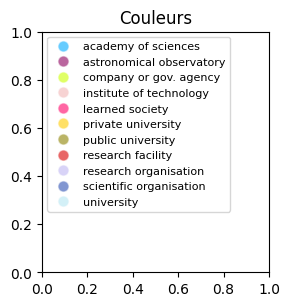

In [116]:

fig = plt.figure(figsize=(3,3))


### Create lists of colors and labels
colors = [color_map.keys()]
 

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=0.6
                            ) for label, color in color_map.items() ],
                            loc='upper left', fontsize=8)
plt.tight_layout() # rect=[0,0,0.8,1]

plt.title('Couleurs')

plt.show()

In [117]:
### Create a function that plots the comparison between values and properties

def compare_with_scatter_plot(dataframe, value_1, value_2, point_column,point_ratio=1, 
                              c_category='', color_map='', figsize=(12,12), 
                              legend_loc='upper right',title='', 
                              n_label ='', label_cut_value=''):

    ### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    # Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
    # Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point



    df=dataframe
    # df_extr=nodes_df[nodes_df.betweenness > 0].sort_values(by='betweenness', ascending=False)

    alpha=0.7

    ### Manage point colors:
    # https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/

    plt.figure(figsize=figsize)


    ### Create lists of colors and labels
    colors = [color_map[category] for category in df[c_category]]
 



    ax = plt.scatter(df[value_1],
                df[value_2],
            marker='o',
            s = [v*point_ratio for i,v in df[point_column].items()],
            color=colors,        
            alpha=alpha)
    plt.xlabel(value_1.capitalize())
    plt.ylabel(value_2.capitalize())






    ### Labels
    test_v1 = df[value_1].quantile([0.97]).item()
    test_v2 = df[value_2].quantile([0.95]).item()
    print(test_v1,test_v2)


    if len(n_label)>0:
        for i,row in list(df.loc[(df[value_1]>test_v1)|(df[value_2]>test_v2)]\
                          [[n_label,value_1,value_2]].iterrows()):
            plt.annotate(row[n_label][:30],(row[value_1], row[value_2]), fontsize=6)

    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                            label=label, markerfacecolor=color, 
                            markersize=8, alpha=alpha
                            ) for label, color in color_map.items() 
                                    if label in types_list ],
                            loc=legend_loc, fontsize=8)
    plt.tight_layout() # rect=[0,0,0.8,1]

    plt.title(title)

    # plt.savefig('plots/revenus_eigenvector_20210526.jpg')
    plt.show()

0.7071067811865476 0.0


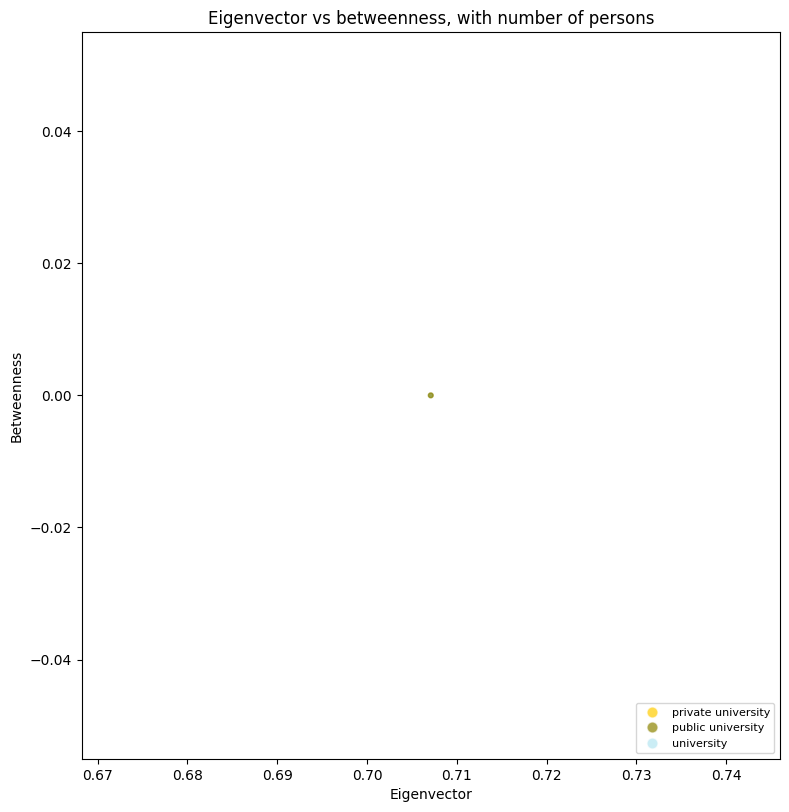

Spearman's rank correlation: nan


In [118]:
compare_with_scatter_plot(nodes_df, 'eigenvector', 'betweenness', 'membersNumber', 
                          point_ratio=3, c_category='mainType',
                          color_map=color_map, figsize=(8,8), 
                          legend_loc='lower right', 
                          title='Eigenvector vs betweenness, with number of persons', 
                          n_label='label', label_cut_value='membersNumber' )

corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
print("Spearman's rank correlation: {}".format(corr_spear.iloc[0,1]))

In [119]:
list(nodes_df.columns)

['id', 'label', 'mainType', 'membersNumber', 'eigenvector', 'betweenness']

In [120]:
print('Betweenness')
pprint.pprint((nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))
print('\n-----\nEigenvector')
pprint.pprint((nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7)))

Betweenness
                                               label           mainType  \
0  Faculty of History and Philology of Moscow Uni...         university   
1                            Moscow State University  public university   

  membersNumber  
0             2  
1             4  

-----
Eigenvector
                                               label           mainType  \
0  Faculty of History and Philology of Moscow Uni...         university   
1                            Moscow State University  public university   

  membersNumber  
0             2  
1             4  


#### Plot graph

In [121]:
pict_addr = 'images/organisations/edu_edu_' + p +'.svg'
print(pict_addr)

images/organisations/edu_edu_1881-1910.svg


/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_19542/452596361.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=60)


FileNotFoundError: [Errno 2] No such file or directory: 'images/organisations/edu_edu_1881-1910.svg'

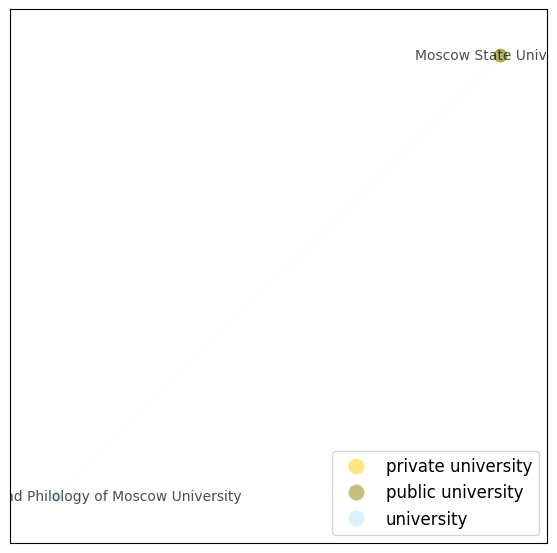

In [124]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]
node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                        label=label, markerfacecolor=color, 
                        markersize=12, alpha=alpha_n
                        )
                        for label, color in color_map.items()
                        if label in types_list ],
                        loc='lower right', fontsize=12)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr
plt.savefig(pict_addr)
#plt.show()
plt.close()


### Communitites

In [123]:
l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
print( len(l_communities))
sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
print([c[1] for c in sl_communities])
print(sl_communities[-1:])


1
[2]
[({'http://www.wikidata.org/entity/Q4204467', 'http://www.wikidata.org/entity/Q13164'}, 2)]


In [ ]:
for i in range(0,5):
   print('\n\nCommunity '+ str(i), '\nBetweenness')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))
   print('\n-----\nEigenvector')
   pprint.pprint((nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(4)))


#### Plot communitites graph

In [ ]:
pict_addr_comm = 'images/organisations/edu_edu_communities_' + p +'.svg'
print(pict_addr_comm)

In [ ]:
### Plot the graph

g = pG
# n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
n_size = np.log(nx.number_of_nodes(g))*10

graph_layout = 'spring_layout'
n_k = np.log(nx.number_of_nodes(g))/20 #2.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
#node_size = [d[1]*100 for d in nx.degree(g)]

node_colors = []
for n in g.nodes.data():
    if n[0] in list(sl_communities[0][0]):
        node_colors.append('red')
    elif n[0] in list(sl_communities[1][0]):
        node_colors.append('blue')
    elif n[0] in list(sl_communities[2][0]):
        node_colors.append('green')
    elif n[0] in list(sl_communities[3][0]):
        node_colors.append('orange')
    elif n[0] in list(sl_communities[4][0]):
        node_colors.append('maroon')
    else:
        node_colors.append('lightGrey')        


edge_size = [e[2]['weight'] for e in g.edges.data()]
edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_colors, alpha=0.6)
nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
#nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

alpha_n=0.5



### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
pict_addr = pict_addr_comm
plt.savefig(pict_addr)
#plt.show()
plt.close()


## Create general function

In [ ]:
def generate_report_and_plots(df, concatRelaType, type_list, doc_addr, df_orgPeriod):

    with open(doc_addr, "w") as myfile:
        myfile.write('# Report for relations: ' + concatRelaType + '\n')


    df_g = df[(df.relaType_concat == concatRelaType) \
                     & (df.orgMainType_x.isin(type_list)) \
                     & (df.orgMainType_y.isin(type_list))  ]

    txt = str(df_g.groupby('periods').size())

    with open(doc_addr, "a") as myfile:
        myfile.write('\n'+txt + '\n')

    for p in df_g['periods'].unique():
        print(str(p))   

        with open(doc_addr, "a") as myfile:
            myfile.write('\n\n\n## Values for ' + p + '\n')

        df_g_p = df_g[df_g.periods==p]
        
        with open(doc_addr, "a") as myfile:
            myfile.write('\nNumber of relationships for this period ' + str(len(df_g_p)) + '\n')
        
        l = [tuple(
            (e['uriOrg_x'], e['uriOrg_y'],
            {'uriPers':e['uriPer'], 'labelPers':e['labelPer'],
            ## the weight ist the number of persons in this relationship
            'weight':e['number']}
            )) 
            for e in df_g_p.to_dict(orient='records')]
        
        graph_p=nx.Graph()
        graph_p.add_edges_from(l)

        txt = 'Number of nodes: ' + str(graph_p.number_of_nodes())+\
                '\nNumber of edges: ' + str(graph_p.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### Components
        graph_p_S = [graph_p.subgraph(c).copy() 
                     for c in nx.connected_components(graph_p)]

        ln = sorted([[i,len(s.nodes)] for i,s in enumerate(graph_p_S)], key = lambda row: row[1], reverse=True)
        try:
            if ln[1][1]*20 < ln[0][1]:
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nJust one big component with ' + str(graph_p_S[0].number_of_nodes()) + ' nodes\n')            
            else :
                with open(doc_addr, "a") as myfile:
                    myfile.write('\nBeware: more than one big component !'  + '\n')
        except Exception as e:
             print(e)            
            
        ### Alternative way with just one graph
        pG = graph_p_S[0]

        txt = 'Number of nodes for first component: ' + str(pG.number_of_nodes())+\
                '\nNumber of edges for first component: ' + str(pG.number_of_edges())
        with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

        ### No treatment for smaller graphs
        if int(pG.number_of_nodes()) > 30:

            ### Prepare data to add to nodes

            df_opl = df_orgPeriod[df_orgPeriod.periods==p][['uriOrg', 'labelOrg', 'orgMainType', 'period_members_number']]
            df_opl.columns=['uri', 'label', 'mainType', 'membersNumber']

            ln = dict([(e['uri'],
                {'label':e['label'], 'mainType':e['mainType'],
                                    'membersNumber':e['membersNumber']}
                ) for e in df_opl.to_dict(orient='records')])
            ## Add attributes
            nx.set_node_attributes(pG, ln)

            mn_s = pd.Series([n[1]['mainType'] for n in pG.nodes.data()])
            txt= str(list(mn_s.groupby(by=mn_s).size().sort_values(ascending=False).items()))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            ### Eigenvector
            try:
                le = list(nx.eigenvector_centrality(pG, 
                                        max_iter=1000, weight='weight').items())
            except Exception as e:
                print(e)    
            nx.set_node_attributes(pG, dict(le), 'eigenvector')   

            ### Betweenness
            lb = list(nx.betweenness_centrality(pG, weight='weight').items())
            nx.set_node_attributes(pG, dict(lb), 'betweenness')


            ### Export node attributes to dataframe
            nodes_data ={node: pG.nodes[node] for node in pG.nodes}
            nodes_df = pd.DataFrame(nodes_data).T
            nodes_df.reset_index(inplace=True, names='id')

            corr_spear = nodes_df[['eigenvector', 'betweenness']].corr(method="spearman")
            txt = "Spearman's rank correlation of eidenvector and betweenness: {}".format(corr_spear.iloc[0,1])
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')

            txt = 'Eigenvector\n' + \
                str(nodes_df.sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(7) )+\
                '\n-----\nBetweenness'+\
                str(nodes_df.sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(7))
            with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ txt  + '\n')


            pict_addr = 'images/organisations/' + concatRelaType + '_' + p +'.svg'        


            ### Plot the graph
            g = pG
            # n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 25 #*25
            n_size = np.log(nx.number_of_nodes(g))*10

            graph_layout = 'spring_layout'
            n_k = np.log(nx.number_of_nodes(g))/20 #2.5

            ### Define the layout, i.e. the choice 
            # of the algorithm for the representation of the graph.

            if graph_layout == 'fruchterman_reingold':
                pos = nx.fruchterman_reingold_layout(g)
            elif graph_layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(g)
            elif graph_layout == 'spring_layout':
                pos = nx.spring_layout(g, k = n_k)  
            else:
                pos = nx.kamada_kawai_layout(g)

            # https://networkx.org/documentation/stable/reference/drawing.html
            plt.figure(figsize = (n_size,n_size))

            node_size = [n[1]['membersNumber']*20 for n in g.nodes.data()]
            #node_size = [d[1]*100 for d in nx.degree(g)]
            #node_colors= [color_map[n[1]['mainType']] for n in g.nodes.data()]

            edge_size = [e[2]['weight'] for e in g.edges.data()]
            edge_labels = {e: g.get_edge_data(e[0], e[1])["weight"] for e in g.edges()}

            node_labels = dict([tuple(( n[0] , n[1]['label'] )) for n in g.nodes.data()])


            nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color='blue', alpha=0.6)
            nx.draw_networkx_edges(g, pos, width=edge_size, alpha=0.02) # edgelist=ln, edge_color=c, 
            nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)
            #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, alpha=0.7, font_size=10)

            alpha_n=0.5

            plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                                    label=label, markerfacecolor=color, 
                                    markersize=8, alpha=alpha_n
                                    )
                                    for label, color in color_map.items()],
                                    loc='lower right', fontsize=8)


            ### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
            plt.tight_layout(pad=60)
            pict_addr = pict_addr
            plt.savefig(pict_addr)
            #plt.show()
            plt.close()


            ### Identify communitites
            l_communities = [(c, len(c)) for c in list(nx.community.louvain_communities(pG, resolution=0.7, weight='weight'))]
            sl_communities = sorted(l_communities, key=lambda x: x[1], reverse=True)
            txt= 'Number of communitites: ' + str(len(l_communities)) +\
                    '\nNumber of nodes per community: ' + str([c[1] for c in sl_communities])
            with open(doc_addr, "a") as myfile:
                myfile.write('\n'+ txt  + '\n')

            communities_print = 'Communities: \n'
            try:
                for i in range(0,5):
                    communities_print += '\n\nCommunity '+ str(i) + '\nBetweenness'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ]\
                                                .sort_values(by='betweenness', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                    communities_print += '\n-----\nEigenvector'
                    communities_print += str(nodes_df[nodes_df.id.isin(list(sl_communities[i][0])) ].sort_values(by='eigenvector', ascending=False)[['label', 'mainType', 'membersNumber']].head(5).to_markdown())
                with open(doc_addr, "a") as myfile:
                    myfile.write('\n'+ communities_print  + '\n')
            except Exception as e:
                 print(e)        

        else:
            print('Too small graph to be analyzed!')        


In [ ]:
print(df_mainTypes.mainType.to_list())

In [ ]:
relationship_type = 'education_education'
generate_report_and_plots(df_graph, relationship_type,
                           ['university','public university','private university'],
                           'analysis_doc/'+relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'membership_membership'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)

In [ ]:
relationship_type = 'employment_employment'
generate_report_and_plots(df_graph, relationship_type,
                           ['university',
                            'public university',
                            'academy of sciences',
                            'learned society',
                            'private university',
                            'research organisation',
                            'institute of technology',
                            'scientific organisation',
                            'astronomical observatory',
                            'research facility',
                            'company',
                            'governmenmt agency',
                            'publisher_edition'],
                           'analysis_doc/'+ relationship_type+'.md',
                           df_orgPeriod)